# **Visualisations**

This section presents key visual insights that support the analysis of climate tipping points. Through scatterplots, boxplots, and regression visuals, the relationships between renewable energy adoption, energy intensity, and CO₂ emissions per capita are explored. These visualisations help uncover patterns, outliers, and potential thresholds critical to understanding the dynamics of global decarbonisation efforts.



In [1]:
# import libraries
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import scipy.stats as stats

# load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features.csv')
df.head()

,country,year,elec_access_pct,clean_fuels_access_pct,renew_cap_kw_pc,climate_finance_usd,renewables_share_pct,fossil_elec_twh,nuclear_elec_twh,renew_elec_twh,...,region_miss,subregion_miss,co2_per_capita_t,log_co2_per_capita_t,log_renewables_share_pct,log_energy_intensity_mj_usd,log_gdp_pc_usd,above_30_pct,year_offset,renewables_3yr_avg
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,0,0,0.037754,0.037059,3.828424,0.970779,5.195324,1,0,44.990000
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,0,0,0.035988,0.035356,3.841601,1.007958,5.195324,1,1,45.295000
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,0,0,0.048180,0.047055,3.659193,0.875469,5.195324,1,2,42.806667
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,0,0,0.053666,0.052276,3.628599,0.875469,5.255847,1,3,40.030000
4,Afghanistan,2004,20.064968,10.9,7.75,0.0,44.24,0.33,0.0,0.56,...,0,0,0.043717,0.042788,3.811982,0.788457,5.358387,1,4,39.576667


In [3]:
# Group countries by region and subregion:

import pandas as pd
from tabulate import tabulate

# Load and clean data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")
df_filtered = df[['region', 'subregion', 'country']].dropna()
df_filtered = df_filtered.drop_duplicates()

# Group by Region and Subregion
grouped = (
    df_filtered
    .groupby(['region', 'subregion'])['country']
    .apply(list)
    .reset_index()
)

# Format countries as left-justified, multiline string
grouped['country_list'] = grouped['country'].apply(lambda x: ", ".join(x))

# Create pretty table with left-justified columns
table_data = [
    [region.ljust(10), subregion.ljust(35), countries]
    for region, subregion, countries in zip(grouped['region'], grouped['subregion'], grouped['country_list'])
]

# Display using tabulate
headers = ["Region", "Subregion", "Countries"]
print(tabulate(table_data, headers=headers, tablefmt="grid", stralign="left"))


+----------+---------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Region   | Subregion                       | Countries                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [4]:
# Energy Mix Transition by Subregion (Sankey Plot)

import pandas as pd
import plotly.graph_objects as go

# Load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')  

# Step 1: Aggregate average renewables share by subregion
df_subregion = df[['subregion', 'renewables_share_pct']].dropna()
avg_renew = df_subregion.groupby('subregion')['renewables_share_pct'].mean().reset_index()

# Step 2: Categorise by level of renewable energy share
def categorize(share):
    if share >= 50:
        return 'High Renewables'
    elif share >= 30:
        return 'Moderate Renewables'
    else:
        return 'Low Renewables'

avg_renew['category'] = avg_renew['renewables_share_pct'].apply(categorize)

# Step 3: Prepare for Sankey
sankey_df = avg_renew[['subregion', 'category']]
sankey_df['count'] = 1

labels = list(sankey_df['subregion'].unique()) + list(sankey_df['category'].unique())
label_to_index = {label: i for i, label in enumerate(labels)}

sources = sankey_df['subregion'].map(label_to_index).tolist()
targets = sankey_df['category'].map(label_to_index).tolist()
values = sankey_df['count'].tolist()

# Step 4: Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightgreen"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0, 128, 0, 0.3)"
    )
)])

fig.update_layout(
    title_text="7. Energy Mix Transition by Subregion (2000 - 2020)",
    font=dict(size=14, color="black", family="Arial"),
    margin=dict(l=100, r=100, t=50, b=50)
)

fig.show()

In [5]:
# Energy Mix Transition by Region (Sankey Plot)

import pandas as pd
import plotly.graph_objects as go

# Load your data
df = pd.read_csv("../data/cleaned/enhanced_energy_features.csv") 

# Categorization logic
def categorize(share):
    if share >= 50:
        return 'High Renewables'
    elif share >= 30:
        return 'Moderate Renewables'
    else:
        return 'Low Renewables'

# Average renewables by region
df_region = df[['region', 'renewables_share_pct']].dropna()
avg_renew = df_region.groupby('region')['renewables_share_pct'].mean().reset_index()
avg_renew['category'] = avg_renew['renewables_share_pct'].apply(categorize)

# Sankey structure
sankey_df = avg_renew[['region', 'category']]
sankey_df['count'] = 1

labels = list(sankey_df['region'].unique()) + list(sankey_df['category'].unique())
label_map = {label: i for i, label in enumerate(labels)}

sources = sankey_df['region'].map(label_map).tolist()
targets = sankey_df['category'].map(label_map).tolist()
values = sankey_df['count'].tolist()

# Sankey chart
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0, 100, 200, 0.3)"
    )
)])

fig.update_layout(
    title_text="Energy Mix Transition by Region (2000 - 2020)",
    font=dict(size=14, color="black", family="Arial"),
    margin=dict(l=100, r=100, t=50, b=50)
)

fig.show()


<Figure size 1200x600 with 0 Axes>

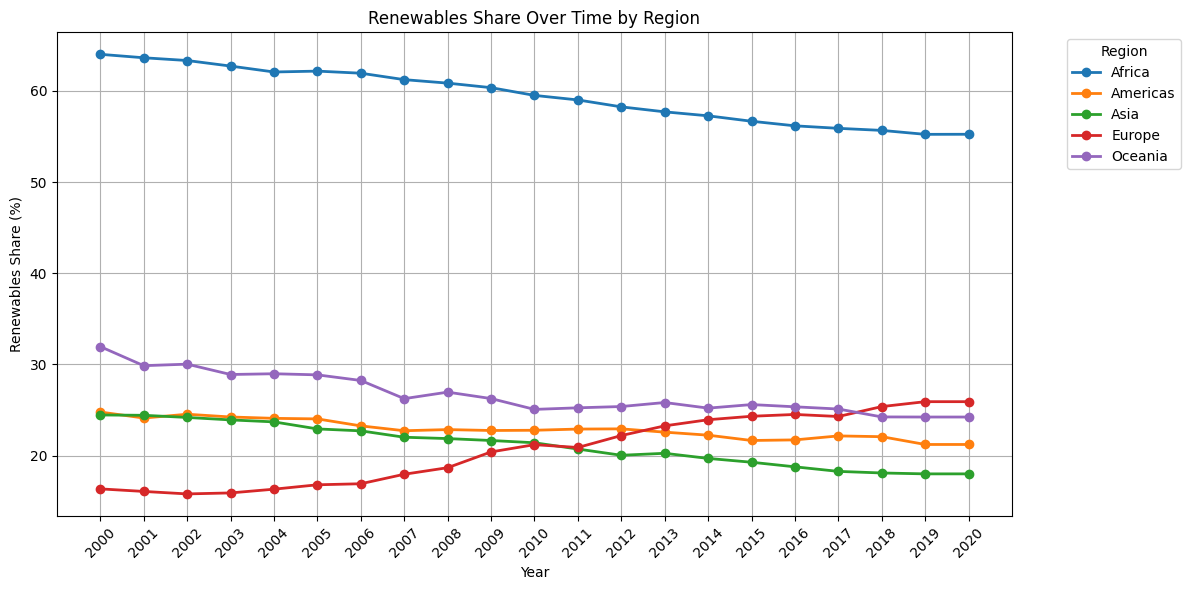

In [5]:
# Create line chart — renewables share over time by region

import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")  

# Step 2: Filter relevant columns and drop NaNs
df_filtered = df[['year', 'region', 'renewables_share_pct']].dropna()

# Ensure year is integer for plotting
df_filtered['year'] = df_filtered['year'].astype(int)

# Step 3: Calculate average renewables share by region per year
df_line = (
    df_filtered
    .groupby(['year', 'region'])['renewables_share_pct']
    .mean()
    .reset_index()
    .pivot(index='year', columns='region', values='renewables_share_pct')
)

# Step 4: Plot line chart
plt.figure(figsize=(12, 6))
df_line.plot(kind='line', marker='o', linewidth=2, figsize=(12, 6))
plt.title('Renewables Share Over Time by Region')
plt.ylabel('Renewables Share (%)')
plt.xlabel('Year')

# Force x-axis ticks to be integers
plt.xticks(df_line.index, df_line.index.astype(int), rotation=45)

# Add legend and grid
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Create a plotly line chart — renewables share over time by subregion

import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features.csv")
df_filtered = df[['year', 'subregion', 'renewables_share_pct']].dropna()
df_filtered['year'] = df_filtered['year'].astype(int)

# Group by year and subregion
df_grouped = (
    df_filtered
    .groupby(['year', 'subregion'])['renewables_share_pct']
    .mean()
    .reset_index()
)

# Plotly line chart
fig = px.line(
    df_grouped,
    x='year',
    y='renewables_share_pct',
    color='subregion',
    title='Renewables Share Over Time by Subregion',
    labels={
        'year': 'Year',
        'renewables_share_pct': 'Renewables Share (%)',
        'subregion': 'Subregion'
    },
    markers=False
)

# Update layout: rotate x-axis ticks and move legend to bottom
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tickangle=45
    ),
    legend_title='Subregion',
    height=600,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.3,         # Adjust if needed
        xanchor="center",
        x=0.5
    )
)

fig.show()
